In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
season_result = pd.read_csv('ext/RegularSeasonCompactResults.csv')
tourney_result = pd.read_csv('ext/NCAATourneyCompactResults.csv')
sample_submission = pd.read_csv('ext/SampleSubmissionStage2.csv')

## Add feature

In [57]:
team_list = sorted(set(season_result.WTeamID) | set(season_result.LTeamID))
n_teams = len(team_list)
team_to_int = {t: i for i, t in enumerate(team_list)}

season_result['team_a'] = season_result.WTeamID.apply(team_to_int.get)
season_result['team_b'] = season_result.LTeamID.apply(team_to_int.get)
season_result['log_ratio'] = np.log(season_result.WScore / season_result.LScore)

tourney_result['team_a'] = tourney_result.WTeamID.apply(team_to_int.get)
tourney_result['team_b'] = tourney_result.LTeamID.apply(team_to_int.get)

sample_submission['team_a'] = sample_submission.ID.apply(lambda a: team_to_int[int(a.split('_')[1])])
sample_submission['team_b'] = sample_submission.ID.apply(lambda a: team_to_int[int(a.split('_')[2])])

In [4]:
def encode_team(d):
    n_samples = d.shape[0]
    a = np.arange(n_samples)
    x = sp.sparse.lil_matrix((n_samples, n_teams))
    x[a, d.team_a] = 1
    x[a, d.team_b] = -1
    return x

## Find best model

### Logistic Regression

In [5]:
def cv_w_c(year_list, w_list, c_list):
    loss_array = np.zeros((len(year_list), len(w_list), len(c_list)))
    for i, year in enumerate(year_list):
        sr = season_result[season_result.Season == year]
        x_sr = encode_team(sr)
        y_sr = np.ones(x_sr.shape[0], dtype=np.int64)
        x_train = sp.sparse.vstack([x_sr, -x_sr])
        y_train = np.concatenate([y_sr, -y_sr])
        log_ratio = np.concatenate([sr.log_ratio, sr.log_ratio])

        tr = tourney_result[tourney_result.Season == year]
        x_tr = encode_team(tr)
        y_tr = np.ones(x_tr.shape[0], dtype=np.int64)
        x_test = sp.sparse.vstack([x_tr, -x_tr])
        y_test = np.concatenate([y_tr, -y_tr])

        for j, w in enumerate(w_list):
            if w is None:
                w_train = None
            else:
                w_train = w * log_ratio.min() + log_ratio
            for k, c in enumerate(c_list):
                cls = LogisticRegression(C=c)
                cls.fit(x_train, y_train, w_train)
                col = list(cls.classes_).index(1)
                y_pred = cls.predict_proba(x_test)[:, col]
                loss = log_loss(y_test, y_pred)
                loss_array[i, j, k] = loss

    return loss_array.mean(0)

In [6]:
def find_c(year_list, w, c_list):
    w_list = [w]
    loss_array = cv_w_c(year_list, w_list, c_list)
    a = divmod(loss_array.argmin(), loss_array.shape[-1])
    print('c_list={}'.format(c_list))
    print('w={} c={} loss={}'.format(w_list[a[0]], c_list[a[1]], loss_array[a]))
    plt.plot(c_list, loss_array[a[0], :])
    plt.show()

In [7]:
year_list = range(2010, 2018)

c_list=[  1.00000000e-03   1.99526231e-03   3.98107171e-03   7.94328235e-03
   1.58489319e-02   3.16227766e-02   6.30957344e-02   1.25892541e-01
   2.51188643e-01   5.01187234e-01   1.00000000e+00   1.99526231e+00
   3.98107171e+00   7.94328235e+00   1.58489319e+01   3.16227766e+01
   6.30957344e+01   1.25892541e+02   2.51188643e+02   5.01187234e+02
   1.00000000e+03]
w=None c=1.0 loss=0.5722201893006443


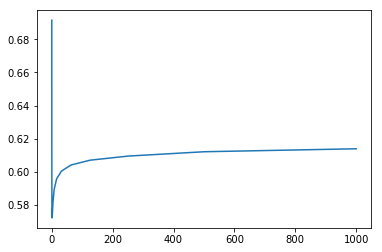

In [8]:
find_c(year_list, None, np.logspace(-3, 3, 21))

c_list=[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2. ]
w=None c=1.1 loss=0.5721941722996348


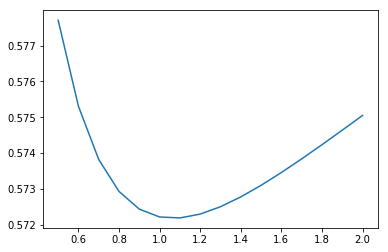

In [9]:
find_c(year_list, None, np.linspace(0.5, 2, 16))

### Weighted Logistic Regression

In [10]:
def find_w(year_list, w_list, c_list):
    loss_array = cv_w_c(year_list, w_list, c_list)
    a = divmod(loss_array.argmin(), loss_array.shape[-1])
    print('w_list={}'.format(w_list))
    print('w={} c={} loss={}'.format(w_list[a[0]], c_list[a[1]], loss_array[a]))
    plt.plot(w_list, loss_array[:, a[1]])
    plt.show()

w_list=[  0.           0.1          0.16681005   0.27825594   0.46415888
   0.77426368   1.29154967   2.15443469   3.59381366   5.9948425   10.        ]
w=2.1544346900318834 c=3.981071705534969 loss=0.56146319351754


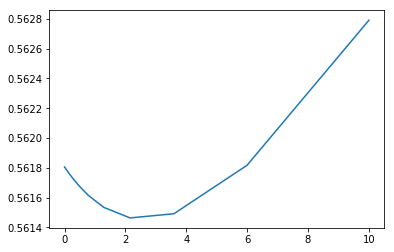

In [11]:
find_w(year_list,
       np.concatenate([np.zeros(1), np.logspace(-1, 1, 10)]),
       np.logspace(-3, 3, 21))

w_list=[ 1.   1.5  2.   2.5  3.   3.5  4. ]
w=2.5 c=3.981071705534969 loss=0.5614549346342018


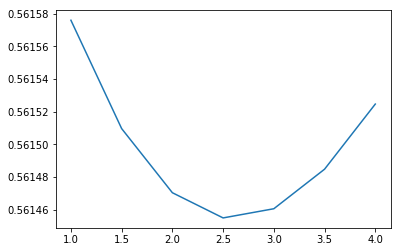

In [12]:
find_w(year_list,
       np.linspace(1, 4, 7),
       np.logspace(-3, 3, 21))

c_list=[ 2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8
  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8
  8. ]
w=2.5 c=3.6 loss=0.5613219623142486


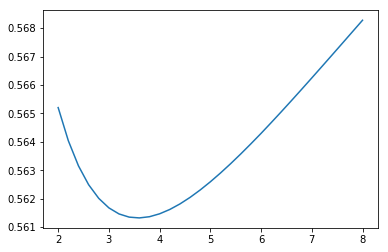

In [13]:
find_c(year_list, 2.5, np.linspace(2, 8, 31))

## Make predication

In [31]:
def predict(w, c, filename):
    year = 2018

    sr = season_result[season_result.Season == year]
    x_sr = encode_team(sr)
    y_sr = np.ones(x_sr.shape[0], dtype=np.int64)
    x_train = sp.sparse.vstack([x_sr, -x_sr])
    y_train = np.concatenate([y_sr, -y_sr])
    log_ratio = np.concatenate([sr.log_ratio, sr.log_ratio])

    x_test = encode_team(sample_submission)

    if w is None:
        w_train = None
    else:
        w_train = w * log_ratio.min() + log_ratio

    cls = LogisticRegression(C=c)
    cls.fit(x_train, y_train, w_train)
    col = list(cls.classes_).index(1)
    y_pred = cls.predict_proba(x_test)[:, col]

    submission = pd.DataFrame()
    submission['ID'] = sample_submission.ID
    submission['Pred'] = y_pred
    submission.to_csv(filename, index=False)

    return cls
lr = predict(w=None, c=1.1, filename='predict_with_logistic.csv')
wlr = predict(w=2.5, c=3.6, filename='predict_with_weighted_logistic.csv')

In [36]:
 year = 2018
w=None
c=1.1
sr = season_result[season_result.Season == year]
x_sr = encode_team(sr)
y_sr = np.ones(x_sr.shape[0], dtype=np.int64)
x_train = sp.sparse.vstack([x_sr, -x_sr])
 y_train = np.concatenate([y_sr, -y_sr])
log_ratio = np.concatenate([sr.log_ratio, sr.log_ratio])

x_test = encode_team(sample_submission)

if w is None:
    w_train = None
else:
    w_train = w * log_ratio.min() + log_ratio


In [37]:

cls = LogisticRegression(C=c)
cls.fit(x_train, y_train, w_train)
col = list(cls.classes_).index(1)
y_pred = cls.predict_proba(x_test)[:, col]

  

In [41]:
submission = pd.DataFrame()
submission['ID'] = sample_submission.ID
submission['Pred'] = y_pred

In [51]:
sample_submission.head()

,ID,Pred,team_a,team_b
0,2018_1104_1112,0.5,3,11
1,2018_1104_1113,0.5,3,12
2,2018_1104_1116,0.5,3,15
3,2018_1104_1120,0.5,3,19
4,2018_1104_1137,0.5,3,36


In [54]:
sub1 =  pd.read_csv('ext/SampleSubmissionStage2.csv')
sub1["team1"] = sub["ID"].apply(lambda x: trans_dict[int(x.split("_")[1])])
sub1["team2"] = sub["ID"].apply(lambda x: trans_dict[int(x.split("_")[2])])
sub1.head()

,ID,Pred,team1,team2
0,2018_1104_1112,0.5,54,2
1,2018_1104_1113,0.5,54,211
2,2018_1104_1116,0.5,54,14
3,2018_1104_1120,0.5,54,15
4,2018_1104_1137,0.5,54,217


In [55]:
sub1["pred"] = y_pred
sub1 = sub1[["ID", "pred"]]
sub1.head()

,ID,pred
0,2018_1104_1112,0.335851
1,2018_1104_1113,0.506103
2,2018_1104_1116,0.403395
3,2018_1104_1120,0.336418
4,2018_1104_1137,0.710202


## Team score

In [58]:
team_score = wlr.coef_[0]
tourney_teams = sorted(set(sample_submission.team_a) | set(sample_submission.team_b))

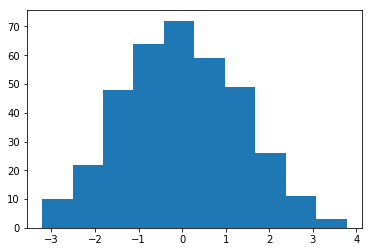

In [46]:
plt.hist(team_score)
plt.show()

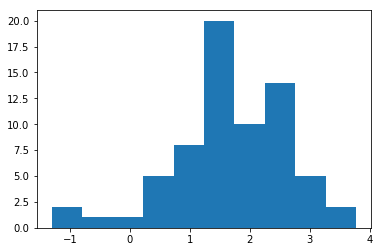

In [47]:
plt.hist(team_score[tourney_teams])
plt.show()

## CL network with Keras
Start by creating the embeddings and bias for the dot products of the 2 teams

In [17]:
simple_df_1 = pd.DataFrame()
simple_df_1[["team1", "team2"]] =season_result[["WTeamID", "LTeamID"]].copy()
simple_df_1["pred"] = 1

simple_df_2 = pd.DataFrame()
simple_df_2[["team1", "team2"]] =season_result[["LTeamID", "WTeamID"]]
simple_df_2["pred"] = 0

simple_df = pd.concat((simple_df_1, simple_df_2), axis=0)
simple_df.head()

,team1,team2,pred
0,1228,1328,1
1,1106,1354,1
2,1112,1223,1
3,1165,1432,1
4,1192,1447,1


In [18]:
n = simple_df.team1.nunique()

In [19]:
n

364

In [20]:
trans_dict = {t: i for i, t in enumerate(simple_df.team1.unique())}
simple_df["team1"] = simple_df["team1"].apply(lambda x: trans_dict[x])
simple_df["team2"] = simple_df["team2"].apply(lambda x: trans_dict[x])
simple_df.head()

,team1,team2,pred
0,0,36,1
1,1,268,1
2,2,175,1
3,3,242,1
4,4,101,1


In [21]:
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, merge
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Model
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Using TensorFlow backend.


In [22]:
train = simple_df.values
np.random.shuffle(train)

In [23]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype="int64", name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [24]:
n_factors = 50

team1_in, t1 = embedding_input("team1_in", n, n_factors, 1e-4)
team2_in, t2 = embedding_input("team2_in", n, n_factors, 1e-4)

b1 = create_bias(team1_in, n)
b2 = create_bias(team2_in, n)

C:\Users\spy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(364, 50, input_length=1, embeddings_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
x = merge([t1, t2], mode="dot")
x = Flatten()(x)
x = merge([x, b1], mode="sum")
x = merge([x, b2], mode="sum")
x = Dense(1, activation="sigmoid")(x)
model = Model([team1_in, team2_in], x)
model.compile(Adam(0.001), loss="binary_crossentropy")

C:\Users\spy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
C:\Users\spy\Anaconda3\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\spy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\spy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
team1_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
team2_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        18200       team1_in[0][0]                   
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        18200       team2_in[0][0]                   
__________________________________________________________________________________________________
merge_1 (M

Now that we have defined our network its time to determine the correct set of numbers that will make our predictions close to actual outputs of a match

Lets learn these numbers by minimising the loss using the Adam optimisation algorithm.

In [27]:
history = model.fit([train[:, 0], train[:, 1]], train[:, 2], batch_size=64, nb_epoch=10, verbose=2)

C:\Users\spy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
 - 12s - loss: 0.6394
Epoch 2/10
 - 10s - loss: 0.6100
Epoch 3/10
 - 10s - loss: 0.6090
Epoch 4/10
 - 10s - loss: 0.6088
Epoch 5/10
 - 10s - loss: 0.6087
Epoch 6/10
 - 10s - loss: 0.6086
Epoch 7/10
 - 10s - loss: 0.6085
Epoch 8/10
 - 10s - loss: 0.6083
Epoch 9/10
 - 10s - loss: 0.6082
Epoch 10/10
 - 10s - loss: 0.6081


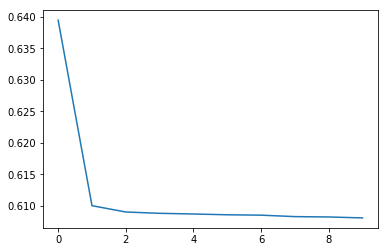

In [28]:
plt.plot(history.history["loss"])
plt.show()

In [29]:
sub =  pd.read_csv('ext/SampleSubmissionStage2.csv')
sub["team1"] = sub["ID"].apply(lambda x: trans_dict[int(x.split("_")[1])])
sub["team2"] = sub["ID"].apply(lambda x: trans_dict[int(x.split("_")[2])])
sub.head()

,ID,Pred,team1,team2
0,2018_1104_1112,0.5,54,2
1,2018_1104_1113,0.5,54,211
2,2018_1104_1116,0.5,54,14
3,2018_1104_1120,0.5,54,15
4,2018_1104_1137,0.5,54,217


In [30]:
sub["pred"] = model.predict([sub.team1, sub.team2])
sub = sub[["ID", "pred"]]
sub.head()

,ID,pred
0,2018_1104_1112,0.315715
1,2018_1104_1113,0.637036
2,2018_1104_1116,0.502392
3,2018_1104_1120,0.619059
4,2018_1104_1137,0.850680
